# 102778-Machine Learning and Quantum Computers
Lucía Jimeno Cavajal 

100013523@alumnos.uimp.es


# **Homework: Estimating errors from random data samples**


This notebook solves the following assignment:

Create a script that generates random data from different distributions and compare:

(a) A normal or Gaussian distribution for different values of the variance and mean

(b) A uniformly random distribution

(c) The beta distribution

Problem 1. Estimate and compare the confidence intervals or error bars obtained for each distribution using Hoeffding's inequality and the Chebyshev inequality (for the latter one, you need to analyze or empirically estimate the variance)

Problem 2. When possible, compare your results to theoretical values

Problem 3. For which distributions does the 68–95–99.7 rule hold? Provide answers via Jupyter notebooks in GitHub or similar hosting server.



## Setup and Imports
We start by importing the main libraries used in this analysis: `numpy`, `scipy`, `matplotlib`, and `pandas`.


In [1]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, uniform, beta

# Fix random seed for reproducibility
np.random.seed(42)



## Generate random data from different distributions 
We define helper functions to:
- Sample random values from each distribution type
- Compute Hoeffding and Chebyshev bounds


In [2]:

def sample_distribution(dist_type, n=1000, **params):
    if dist_type == 'normal':
        return np.random.normal(params.get('mu', 0), params.get('sigma', 1), n)
    elif dist_type == 'uniform':
        return np.random.uniform(params.get('a', 0), params.get('b', 1), n)
    elif dist_type == 'beta':
        return np.random.beta(params.get('alpha', 2), params.get('beta', 5), n)
    else:
        raise ValueError("Unknown distribution")

def hoeffding_bound(n, epsilon, a, b):
    return 2 * np.exp(-2 * n * epsilon**2 / (b - a)**2)

def chebyshev_bound(var, epsilon):
    return var / epsilon**2



### Experiment Parameters
We define the parameters for sampling and specify the distributions to compare


In [3]:

n = 100
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5]

distributions = {
    'Normal(0,1)': ('normal', {'mu': 0, 'sigma': 1, 'a': -np.inf, 'b': np.inf}),
    'Uniform(0,1)': ('uniform', {'a': 0, 'b': 1}),
    'Beta(2,5)': ('beta', {'alpha': 2, 'beta': 5, 'a': 0, 'b': 1})
}

results = {}

for name, (dtype, params) in distributions.items():
    X = sample_distribution(dtype, n, **params)
    mean_emp = np.mean(X)
    var_emp = np.var(X)
    a, b = params.get('a', np.min(X)), params.get('b', np.max(X))

    probs = []
    for eps in epsilons:
        hoeff = hoeffding_bound(n, eps, a, b) if np.isfinite(a) and np.isfinite(b) else np.nan
        cheb = chebyshev_bound(var_emp, eps)
        probs.append((eps, hoeff, cheb))
    results[name] = {'mean': mean_emp, 'var': var_emp, 'bounds': probs}

results


{'Normal(0,1)': {'mean': np.float64(-0.10384651739409384),
  'var': np.float64(0.8165221946938584),
  'bounds': [(0.1, nan, np.float64(81.65221946938583)),
   (0.2, nan, np.float64(20.413054867346457)),
   (0.3, nan, np.float64(9.072468829931761)),
   (0.4, nan, np.float64(5.103263716836614)),
   (0.5, nan, np.float64(3.266088778775434))]},
 'Uniform(0,1)': {'mean': np.float64(0.48620618511478353),
  'var': np.float64(0.08219665181648621),
  'bounds': [(0.1,
    np.float64(0.27067056647322524),
    np.float64(8.219665181648619)),
   (0.2, np.float64(0.0006709252558050225), np.float64(2.0549162954121547)),
   (0.3, np.float64(3.045995948942526e-08), np.float64(0.9132961312942912)),
   (0.4, np.float64(2.532833109818817e-14), np.float64(0.5137290738530387)),
   (0.5,
    np.float64(3.8574996959278356e-22),
    np.float64(0.32878660726594483))]},
 'Beta(2,5)': {'mean': np.float64(0.2668165092936113),
  'var': np.float64(0.020913098742710457),
  'bounds': [(0.1,
    np.float64(0.2706705664

### Confidence Intervals and Error Bars using Hoeffding and Chebyshev

In [4]:


alpha = 0.05  # 95% confidence level

def hoeffding_interval(mean_emp, a, b, n, alpha):
    eps = (b - a) * np.sqrt(np.log(2 / alpha) / (2 * n))
    return mean_emp - eps, mean_emp + eps, eps

def chebyshev_interval(mean_emp, var_emp, n, alpha):
    eps = np.sqrt(var_emp / (alpha * n))
    return mean_emp - eps, mean_emp + eps, eps

interval_results = []

for name, (dtype, params) in distributions.items():
    X = sample_distribution(dtype, n, **params)
    mean_emp = np.mean(X)
    var_emp = np.var(X)
    a, b = params.get('a', np.min(X)), params.get('b', np.max(X))

    if np.isfinite(a) and np.isfinite(b):
        ci_hoeff_low, ci_hoeff_high, eps_h = hoeffding_interval(mean_emp, a, b, n, alpha)
    else:
        ci_hoeff_low, ci_hoeff_high, eps_h = np.nan, np.nan, np.nan

    ci_cheb_low, ci_cheb_high, eps_c = chebyshev_interval(mean_emp, var_emp, n, alpha)

    interval_results.append({
        "Distribution": name,
        "Empirical Mean": round(mean_emp, 4),
        "Variance": round(var_emp, 4),
        "Hoeffding CI (95%)": f"[{ci_hoeff_low:.4f}, {ci_hoeff_high:.4f}]" if np.isfinite(a) else "N/A (unbounded)",
        "Chebyshev CI (95%)": f"[{ci_cheb_low:.4f}, {ci_cheb_high:.4f}]"
    })

df_intervals = pd.DataFrame(interval_results)
display(df_intervals)

,Distribution,Empirical Mean,Variance,Hoeffding CI (95%),Chebyshev CI (95%)
0,"Normal(0,1)",-0.0306,0.9443,N/A (unbounded),"[-0.4651, 0.4040]"
1,"Uniform(0,1)",0.4495,0.0860,"[0.3137, 0.5853]","[0.3183, 0.5806]"
2,"Beta(2,5)",0.2815,0.0202,"[0.1457, 0.4173]","[0.2179, 0.3451]"


## Comparison of Error Bar Widths (95% CIs)
We now plot the error radius ε for each distribution and inequality. Instead of plotting both bounds of the interval, we plot only ε, which represents how far the estimated mean can deviate from the true mean with 95% confidence

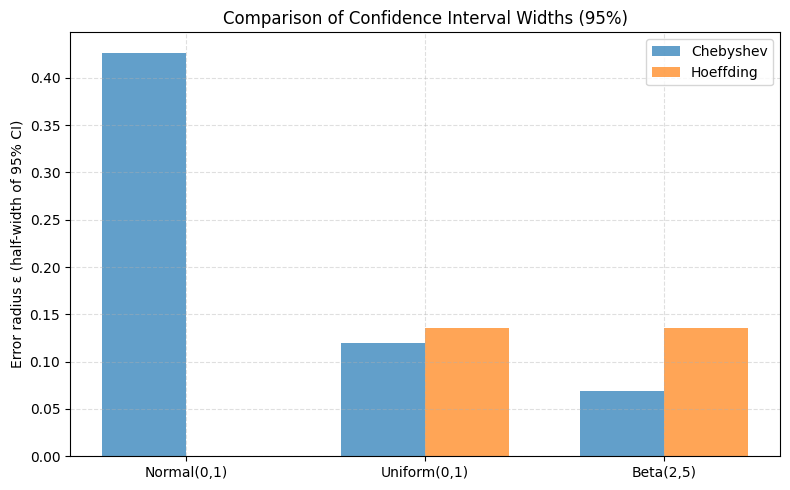

In [5]:


fig, ax = plt.subplots(figsize=(8, 5))
labels = list(distributions.keys())
errors_hoeff, errors_cheb = [], []

for _, (dtype, params) in distributions.items():
    X = sample_distribution(dtype, n, **params)
    mean_emp = np.mean(X)
    var_emp = np.var(X)
    a, b = params.get('a', np.min(X)), params.get('b', np.max(X))
    _, _, eps_h = hoeffding_interval(mean_emp, a, b, n, alpha) if np.isfinite(a) and np.isfinite(b) else (np.nan, np.nan, np.nan)
    _, _, eps_c = chebyshev_interval(mean_emp, var_emp, n, alpha)
    errors_hoeff.append(eps_h)
    errors_cheb.append(eps_c)

x = np.arange(len(labels))
width = 0.35
ax.bar(x - width/2, errors_cheb, width, label='Chebyshev', alpha=0.7)
ax.bar(x + width/2, errors_hoeff, width, label='Hoeffding', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Error radius ε (half-width of 95% CI)')
ax.set_title('Comparison of Confidence Interval Widths (95%)')
ax.legend()
ax.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()


As we can see, for the Normal distribution (0,1) only Chebyshev applies since Hoeffding requires bounded variables.
As expected, Chebyshev produces a very wide bound because it does not exploit any range limitations.

For the Uniform(0,1) and Beta(2,5) distributions, both inequalities can be applied and we see that Hoeffding’s bounds are wider than Chebyshev’s in this case



## Problem 2. When possible, compare your results to theoretical values
We compute the empirical and theoretical variance for each distribution


In [6]:

def theoretical_variance(dist_name, params):
    if dist_name == 'normal':
        return params['sigma']**2
    elif dist_name == 'uniform':
        a, b = params['a'], params['b']
        return (b - a)**2 / 12
    elif dist_name == 'beta':
        α, β = params['alpha'], params['beta']
        return (α * β) / (((α + β)**2) * (α + β + 1))
    else:
        return np.nan

summary = []
for name, (dtype, params) in distributions.items():
    X = sample_distribution(dtype, n, **params)
    var_emp = np.var(X)
    var_th = theoretical_variance(dtype, params)
    summary.append({
        'Distribution': name,
        'Empirical Variance': var_emp,
        'Theoretical Variance': var_th,
        'Bounded?': 'Yes' if np.isfinite(params.get('a', -np.inf)) and np.isfinite(params.get('b', np.inf)) else 'No'
    })

df = pd.DataFrame(summary)
display(df.round(5))


,Distribution,Empirical Variance,Theoretical Variance,Bounded?
0,"Normal(0,1)",0.75059,1.00000,No
1,"Uniform(0,1)",0.08568,0.08333,Yes
2,"Beta(2,5)",0.02210,0.02551,Yes



 ### Visualization of Hoeffding vs Chebyshev Bounds:
We plot both inequalities for each distribution to see the comparison. We use a logarithmic Y-axis to see more clearly differences in order of magnitude


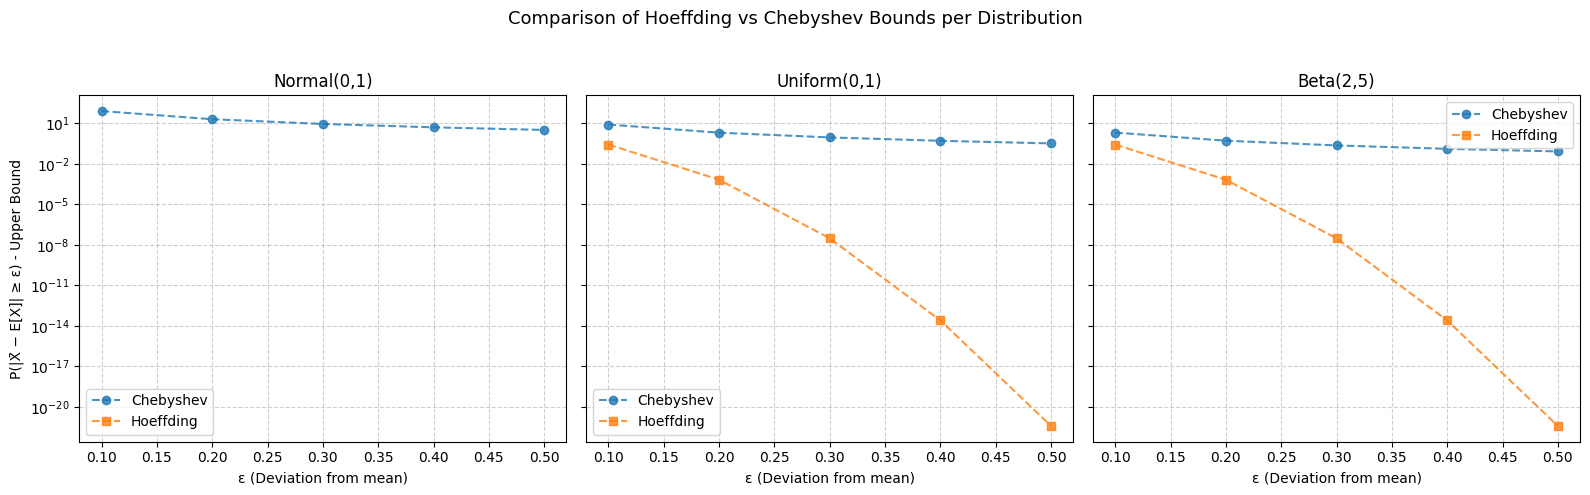

In [7]:

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for ax, (name, data) in zip(axes, results.items()):
    eps_vals = [p[0] for p in data['bounds']]
    hoeff_vals = [p[1] for p in data['bounds']]
    cheb_vals = [p[2] for p in data['bounds']]

    ax.plot(eps_vals, cheb_vals, 'o--', label="Chebyshev", alpha=0.8)
    ax.plot(eps_vals, hoeff_vals, 's--', label="Hoeffding", alpha=0.8)

    ax.set_title(name)
    ax.set_xlabel("ε (Deviation from mean)")
    ax.set_yscale('log')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

axes[0].set_ylabel("P(|X̄ − E[X]| ≥ ε) - Upper Bound")
fig.suptitle("Comparison of Hoeffding vs Chebyshev Bounds per Distribution", fontsize=13)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


For the Normal distribution (0,1) only Chebyshev’s inequality applies, since Hoeffding requires bounded variables. In this case the blue curve remains almost constant and quite high, showing that Chebyshev gives a very loose bound for unbounded distributions.

On the other hand, we can apply Hoeffding for the Uniform (0,1) and Beta (2,5) distributions since they are bounded.
Hoeffding’s inequality gives a more realistic bound for bounded distributions, especially for moderate ε values, while Chebyshev’s inequality, produces weaker and less practical bounds, particularly for unbounded or asymmetric distributions.

This comparison reinforces that knowing whether a distribution is bounded or not is key to choosing the most effective inequality.


## Problem 3. For which distributions does the 68–95–99.7 rule hold?
This rule states that in a normal Gaussian curve about 68% of the values lie within one standard deviation of the mean, about 95% within two, and about 99.7% within three


In [8]:


# Function to calculate empirical coverage
def empirical_rule_test(data, mu, sigma):
    within_1 = np.mean((data >= mu - sigma) & (data <= mu + sigma))
    within_2 = np.mean((data >= mu - 2*sigma) & (data <= mu + 2*sigma))
    within_3 = np.mean((data >= mu - 3*sigma) & (data <= mu + 3*sigma))
    return within_1, within_2, within_3

empirical_results = []

# We compute empirical and theoretical-based coverage for each distribution
for name, (dtype, params) in distributions.items():
    data = sample_distribution(dtype, n=10000, **params)
    mu_emp, sigma_emp = np.mean(data), np.std(data)
    
    # Theoretical standard deviation 
    var_th = theoretical_variance(dtype, params)
    sigma_th = np.sqrt(var_th) if not np.isnan(var_th) else sigma_emp

    # Empirical σ 
    e1_emp, e2_emp, e3_emp = empirical_rule_test(data, mu_emp, sigma_emp)

    # Theoretical σ 
    e1_th, e2_th, e3_th = empirical_rule_test(data, mu_emp, sigma_th)

    empirical_results.append({
        "Distribution": name,
        "Empirical ±1σ (%)": round(e1_emp*100, 2),
        "Empirical ±2σ (%)": round(e2_emp*100, 2),
        "Empirical ±3σ (%)": round(e3_emp*100, 2),
        "Theoretical ±1σ (%)": round(e1_th*100, 2),
        "Theoretical ±2σ (%)": round(e2_th*100, 2),
        "Theoretical ±3σ (%)": round(e3_th*100, 2)
    })

df_empirical = pd.DataFrame(empirical_results)
display(df_empirical)

print("Expected theoretical coverage for Normal(0,1): 68%, 95%, 99.7%")


,Distribution,Empirical ±1σ (%),Empirical ±2σ (%),Empirical ±3σ (%),Theoretical ±1σ (%),Theoretical ±2σ (%),Theoretical ±3σ (%)
0,"Normal(0,1)",67.89,95.58,99.73,67.61,95.33,99.7
1,"Uniform(0,1)",58.53,100.00,100.00,58.72,100.00,100.0
2,"Beta(2,5)",66.40,96.21,99.67,66.94,96.36,99.7


Expected theoretical coverage for Normal(0,1): 68%, 95%, 99.7%


The 68–95–99.7 rule  fits almost perfectly with the Normal distribution, as expected from its symmetry and well-known shape.
However, for Uniform and Beta distributions the results don’t follow this rule as closely, mainly because they are bounded or asymmetric.


##  Conclusions
For the Uniform and Beta distributions (bounded), Hoeffding’s inequality is theoretically expected to produce tighter bounds. However, in our results we have obtained wider confidence intervals, especially for the Beta(2,5) distribution. 
This may be expected to happen because Hoeffding´s inequality depends only on the total range (b − a), ignoring how the data is actually distributed. Since the Beta distribution is asymmetric and highly concentrated near lower values, Hoeffding’s bound becomes more conservative, while Chebyshev’s inequality, which uses the variance, adapts better to its smaller spread.

Chebyshev’s inequality has provided narrower intervals for the bounded distributions because Its dependence on the variance makes it more flexible in these cases.

For the Normal distribution, which is unbounded, Hoeffding´s inequality cannot be applied directly but Chebyshev´s has provided a valid bound, though wide.
